# 데이터셋
데이터 : 32명의 실험자가 모두 40개의 비디오를 각각 60초 시청한 후, 발생한 뇌의 전기적 신호(eeg 장치로)를 기록
* channel : eeg 실험에서 배치한 40개의 전극 (행 개수)
* data : 128 Hz * 63초 = 8064 (열 개수) (시계열 데이터)
> 40번 의 시도 -> 40개의 (40*8064) 배열

레이블 : 40번의 시도 각각의 valence, arousal, dominance, liking 네 주제의 level 을 기록


<처리 완료>

downsampling 500Hz -> 128Hz


<처리 해야 할>

앞의 3초 eeg 신호 제거

국제표준 channel -> 앞 32개

valence 랑 arousual 만

>STFT : 뇌파 변환시켜 주파수로 나타내면 각 수치에 따라 특정한 특징이 나타남
(4~45 Hz 만 보기)



# mat파일 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from scipy import io
import numpy as np

one = io.loadmat('/content/drive/MyDrive/data_preprocessed_matlab/s01.mat')
data = one['data']
label = one['labels']

dirlist = os.listdir('/content/drive/MyDrive/data_preprocessed_matlab')
dirlist = sorted(dirlist, key = lambda x : x[1:3])
for i in dirlist[1:]:
    mat_file = io.loadmat('/content/drive/MyDrive/data_preprocessed_matlab/' + i)
    #각 배열을 array로 저장
    data = np.concatenate((data, mat_file['data']), axis = 0)
    label = np.concatenate((label, mat_file['labels']), axis = 0)


print(np.shape(data))
print(np.shape(label))

(1280, 40, 8064)
(1280, 4)


#데이터 전처리

In [ ]:
#valence, arousal 만 남기고 제거
label = label[:, :2]

#40 trials x 32 channels x (128Hz x 60s)
data = data[:, :32, 384:]


print(label)


[[7.71 7.6 ]
 [8.1  7.31]
 [8.58 7.54]
 ...
 [3.05 7.01]
 [3.99 7.17]
 [7.15 4.03]]


In [ ]:
label_re = label.reshape(32, 40, 2)

**개인별로 label 살펴보기**

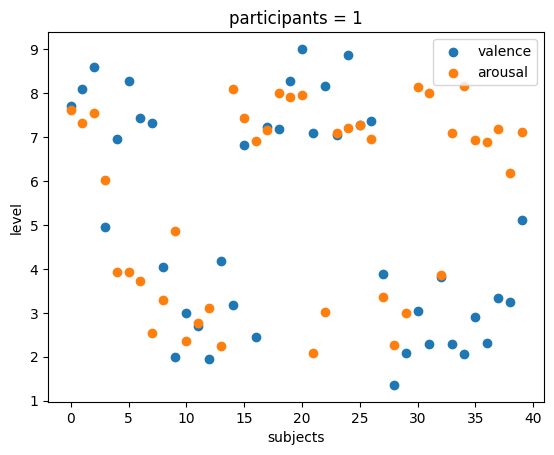

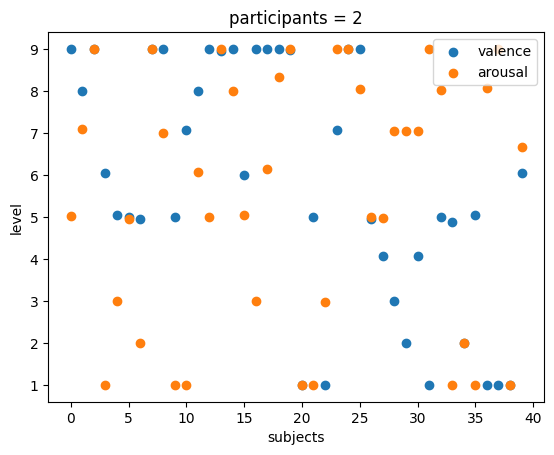

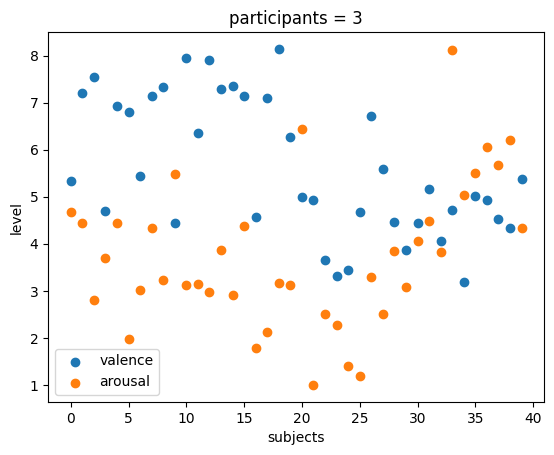

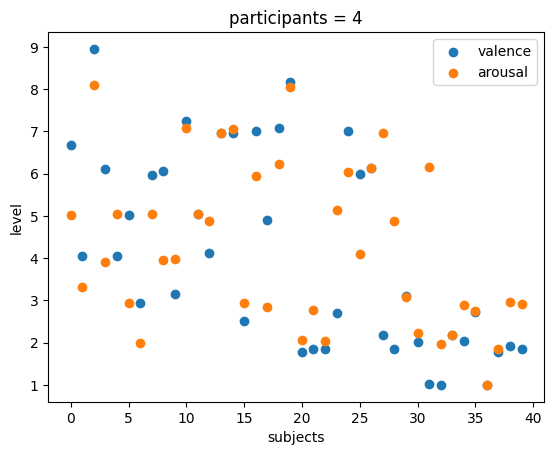

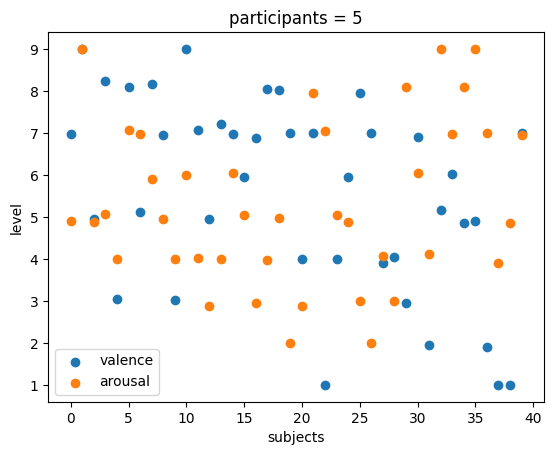

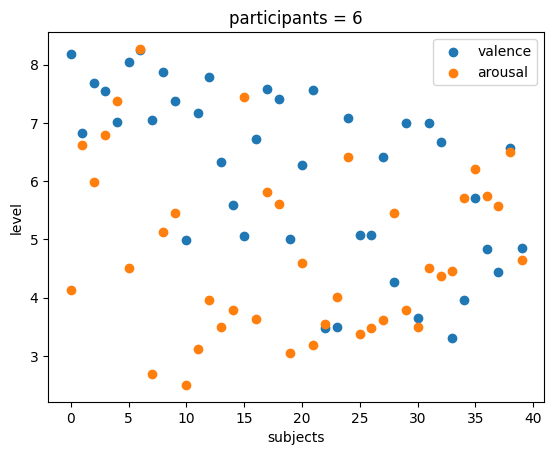

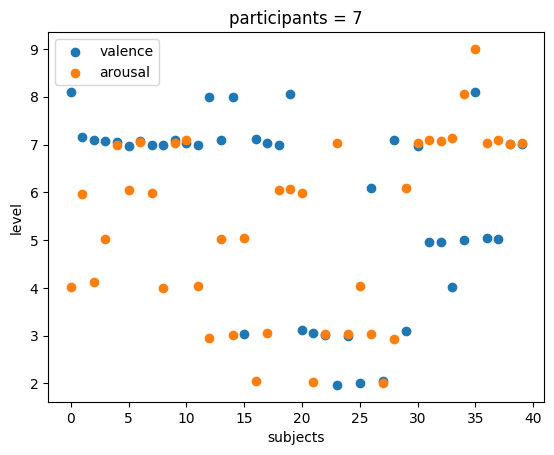

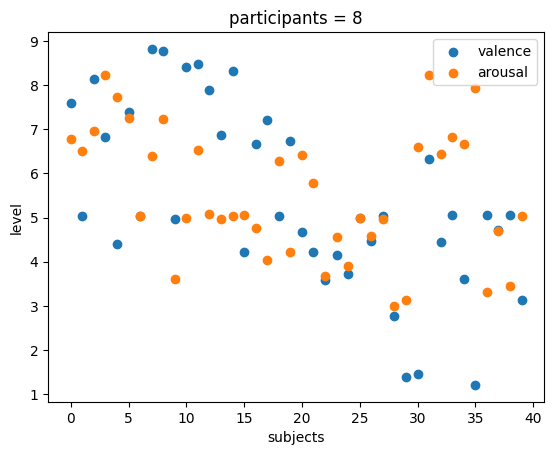

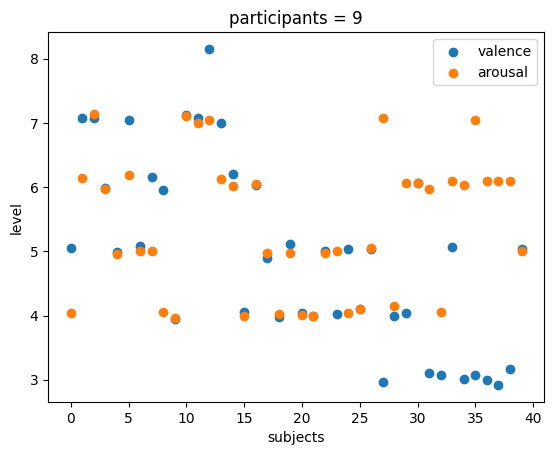

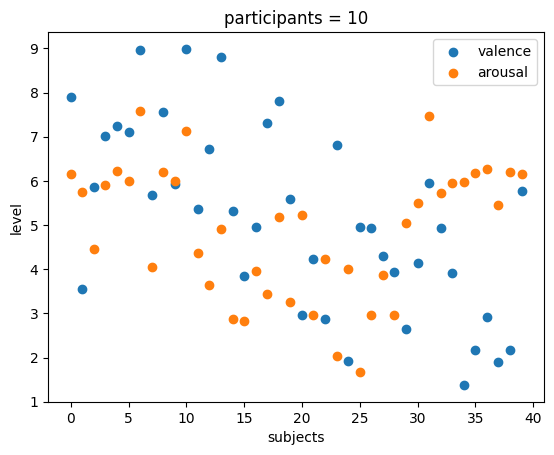

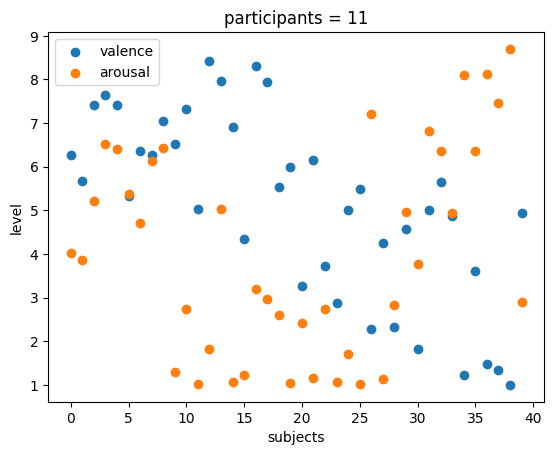

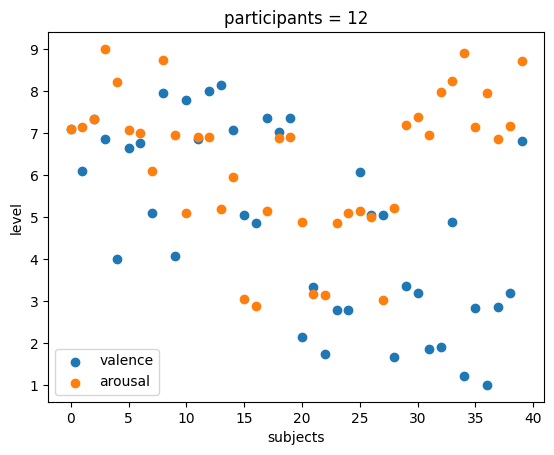

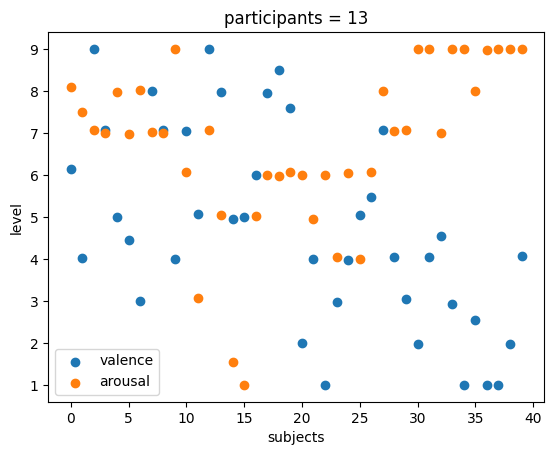

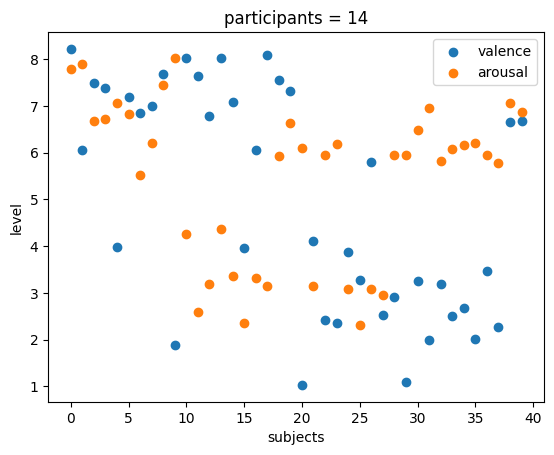

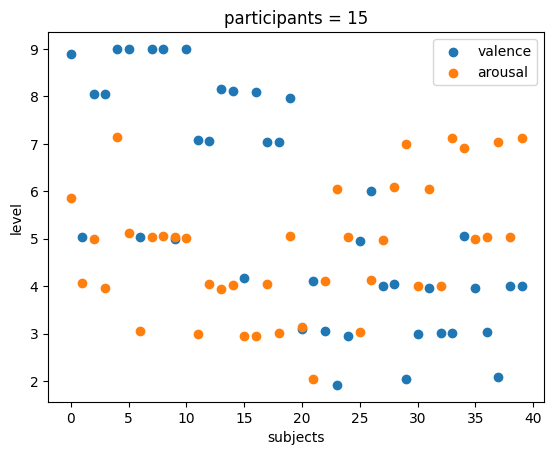

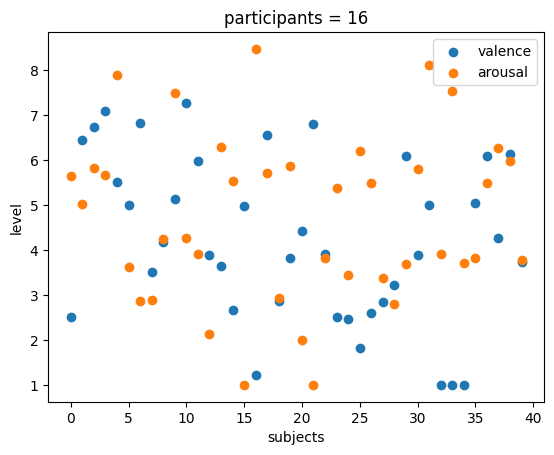

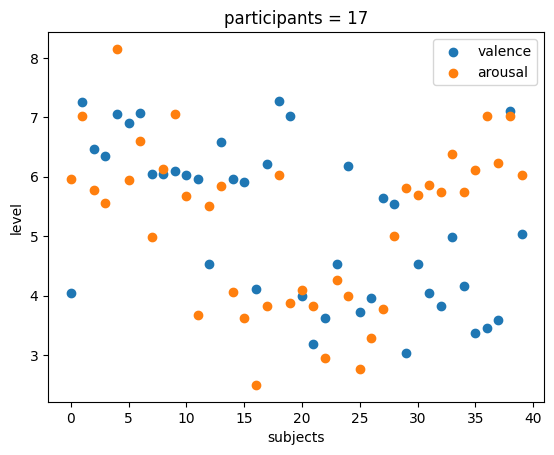

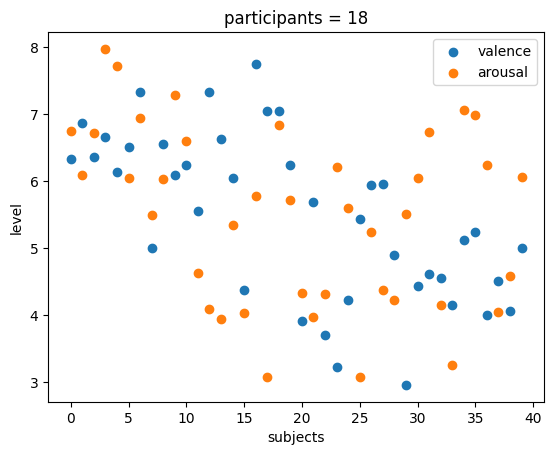

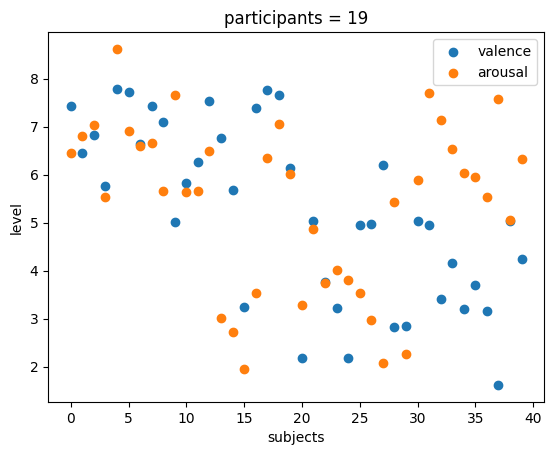

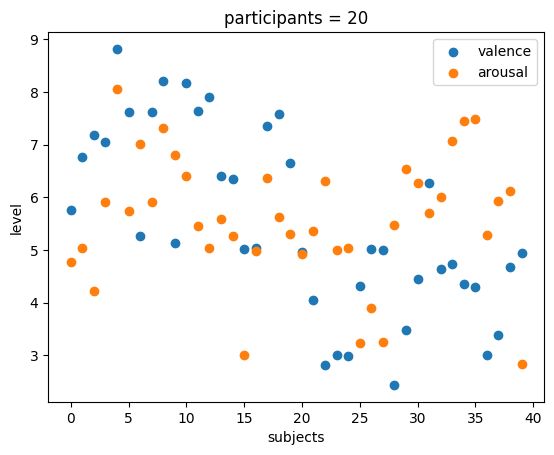

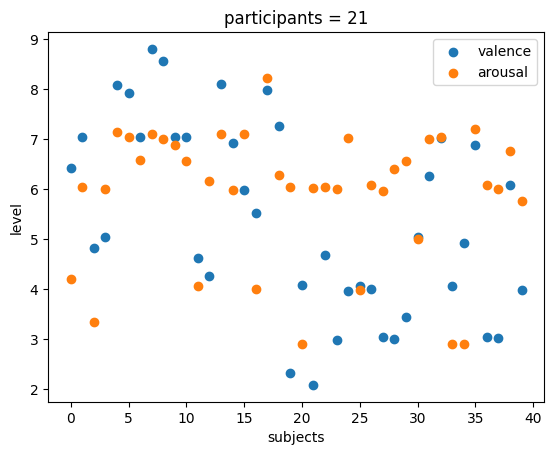

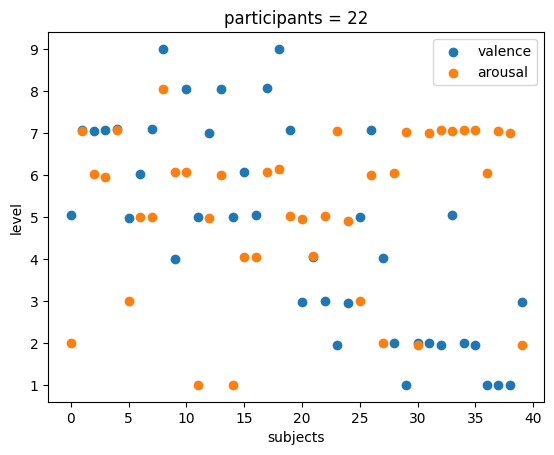

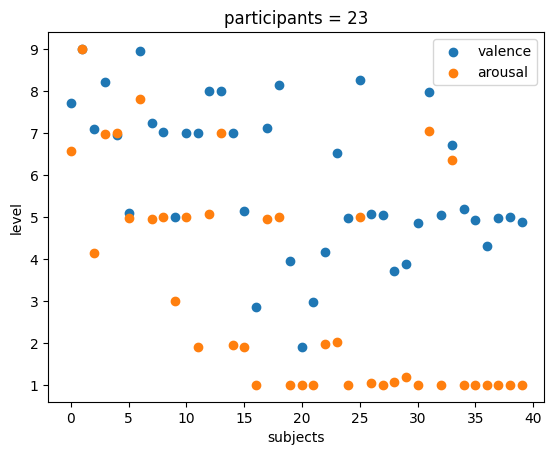

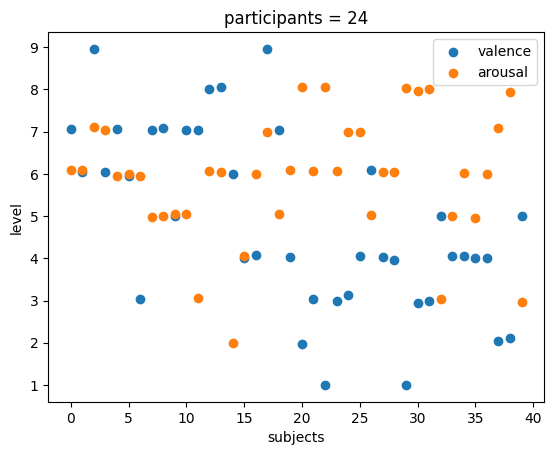

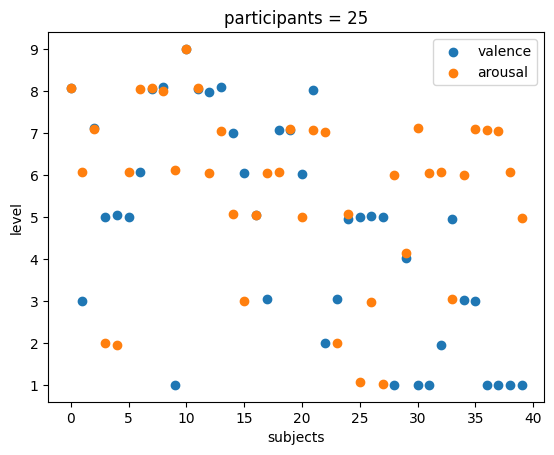

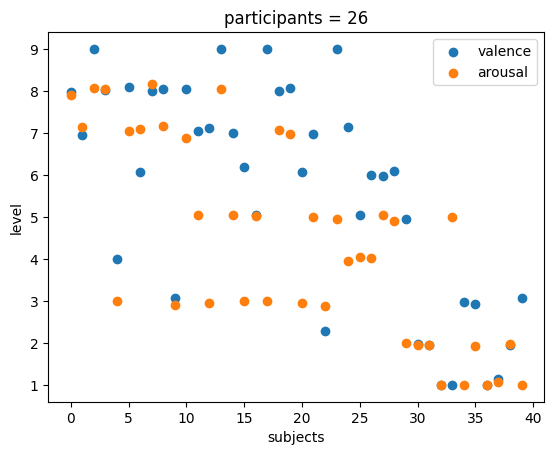

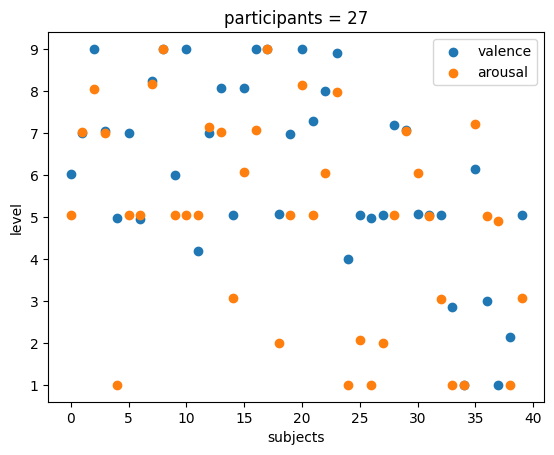

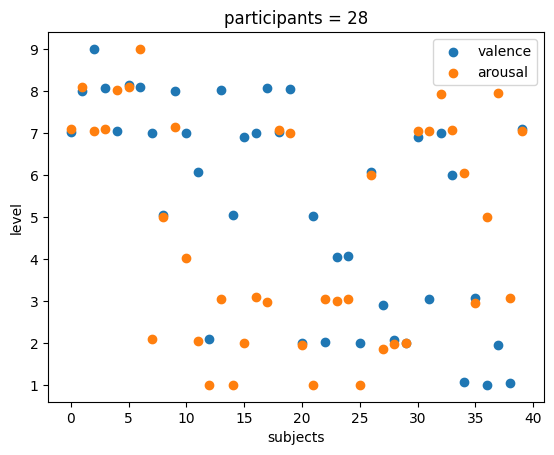

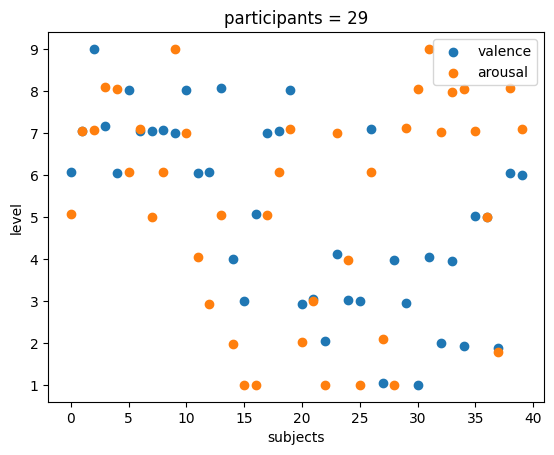

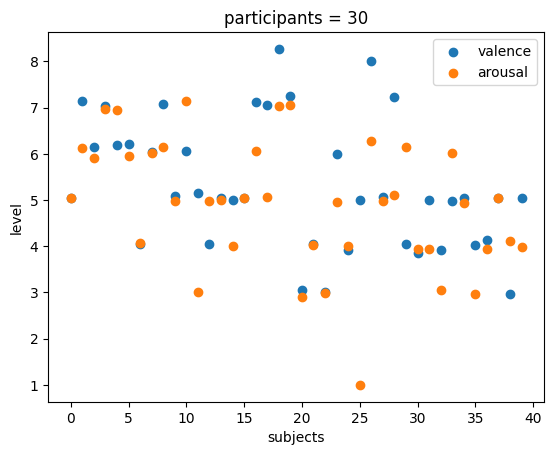

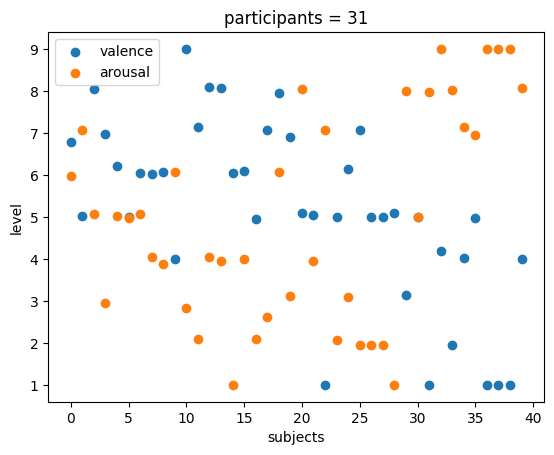

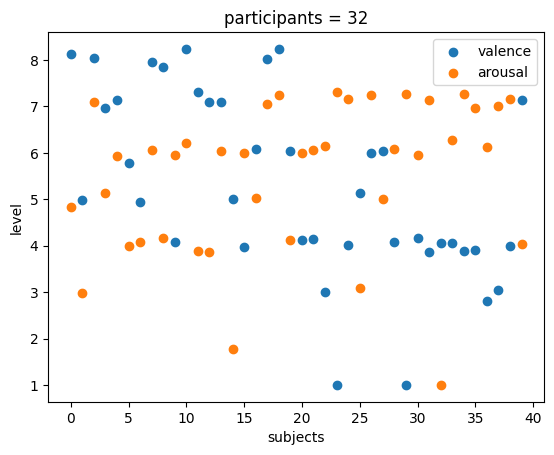

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

x = np.arange(40)
i =1
for l in label_re:

    plt.scatter(x, l[:, 0], label = 'valence')
    plt.scatter(x, l[:, 1], label = 'arousal')
    plt.title('participants = {}'.format(i))
    plt.xlabel('subjects')
    plt.ylabel('level')
    plt.legend()
    plt.show()
    i+=1

valence 와 arousal 의 level 분포가 대체로 고른 편이나 3번째 참가자 처럼 편향된 경우도 존재한다.

(40, 32)


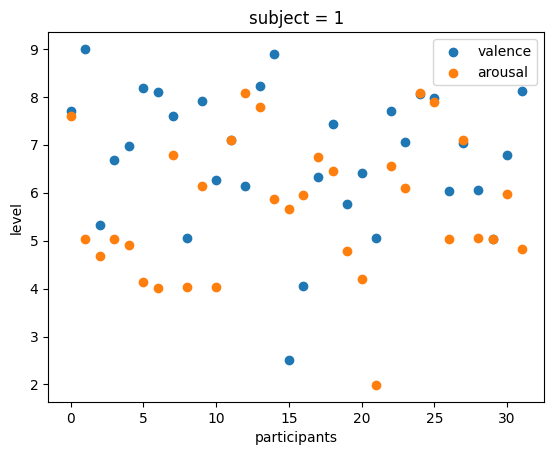

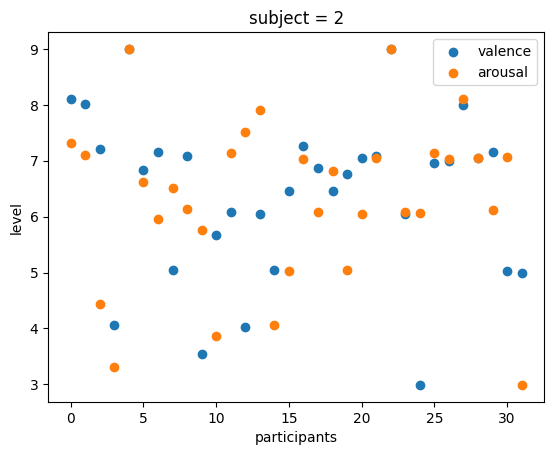

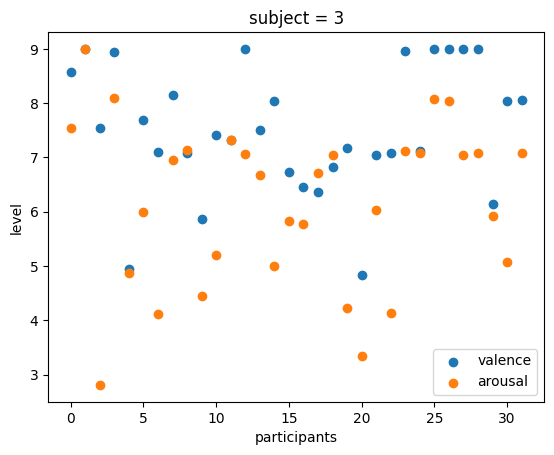

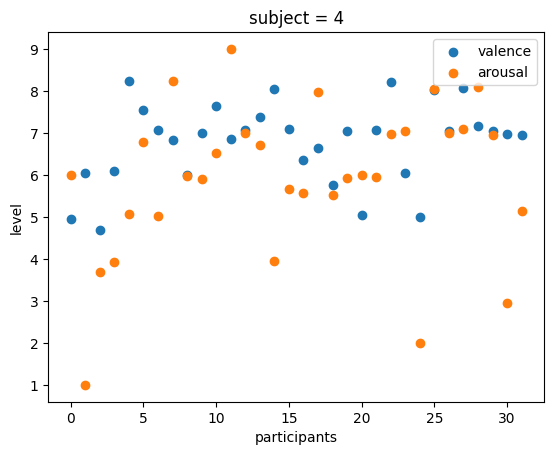

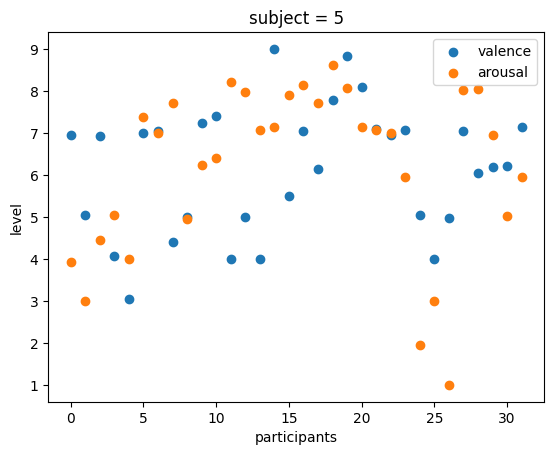

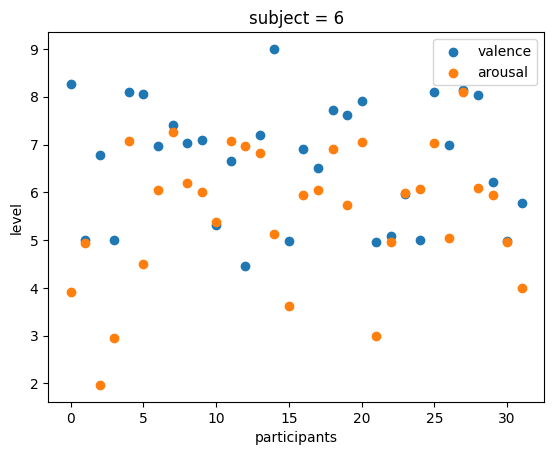

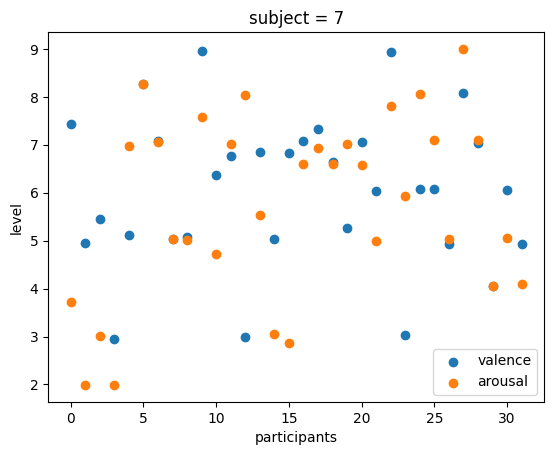

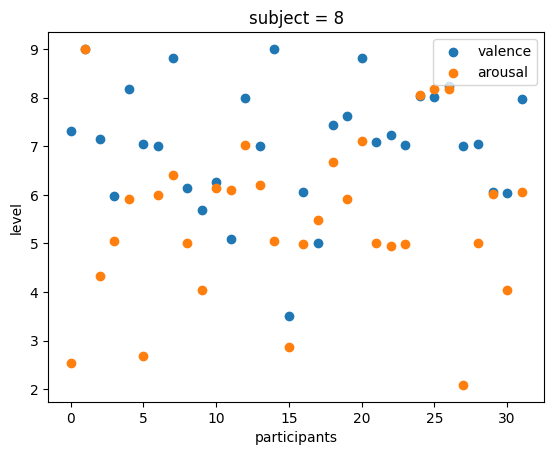

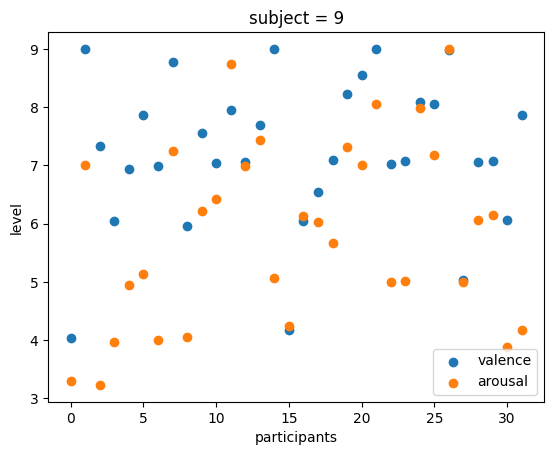

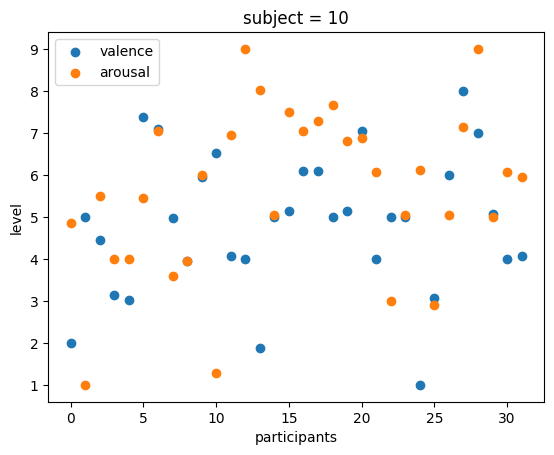

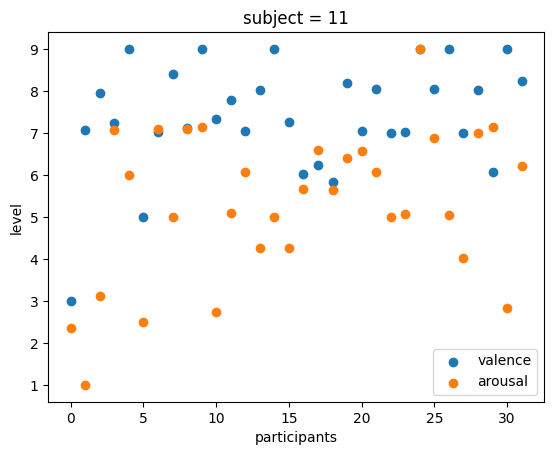

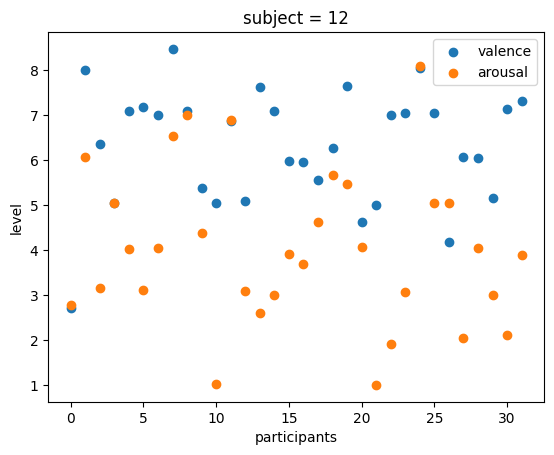

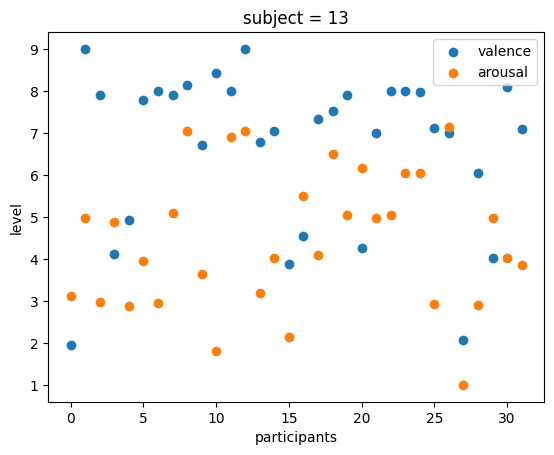

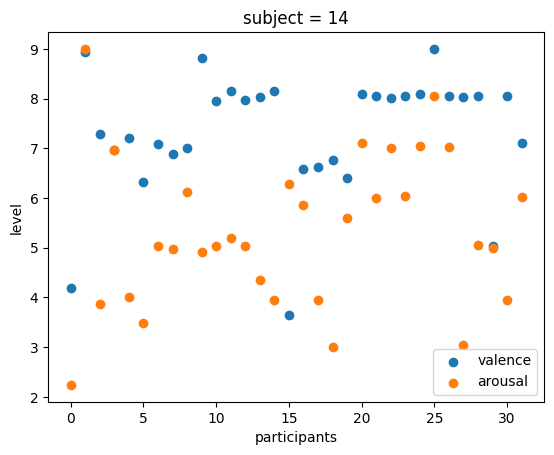

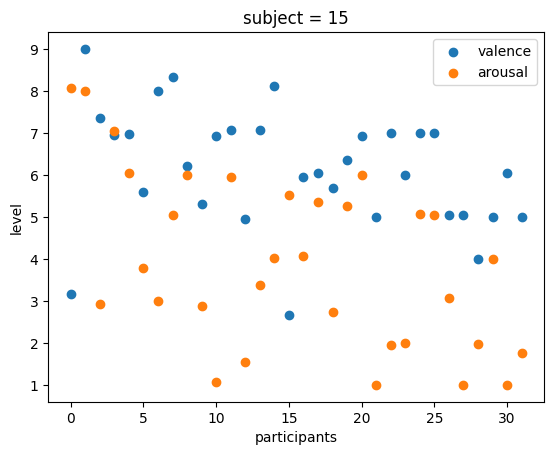

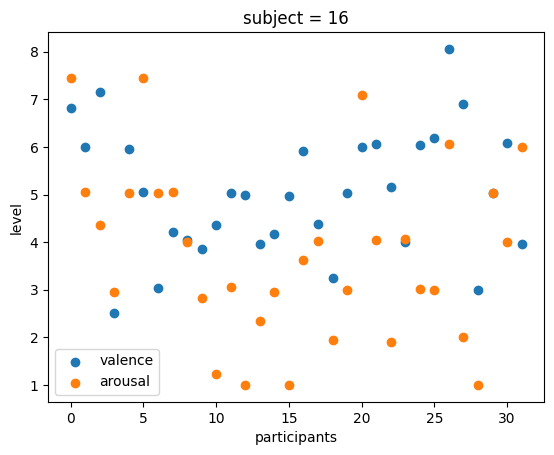

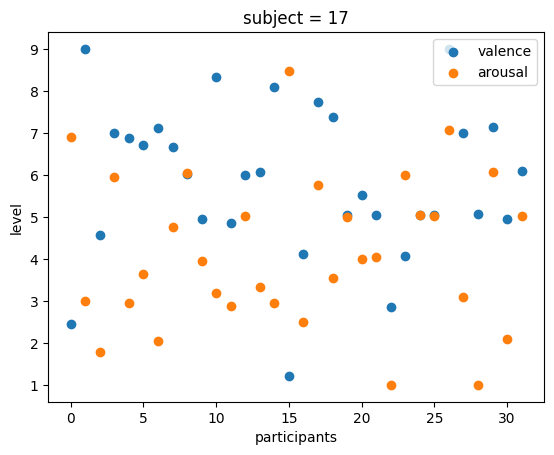

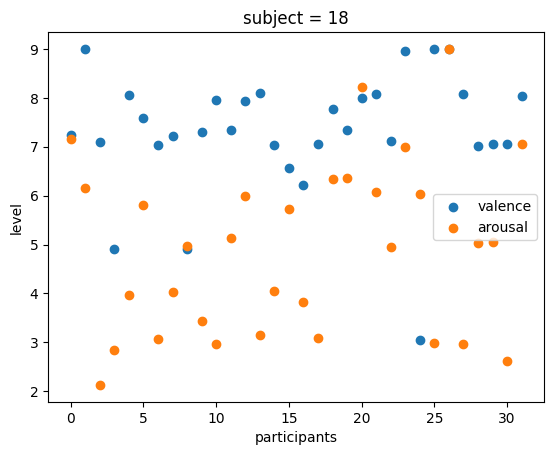

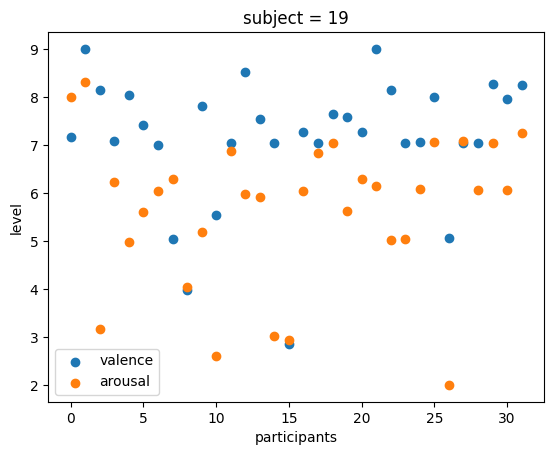

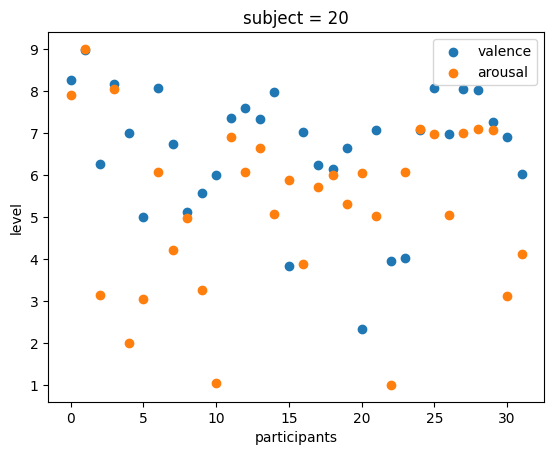

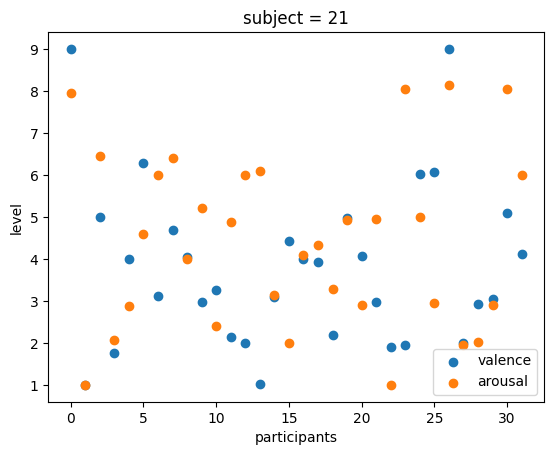

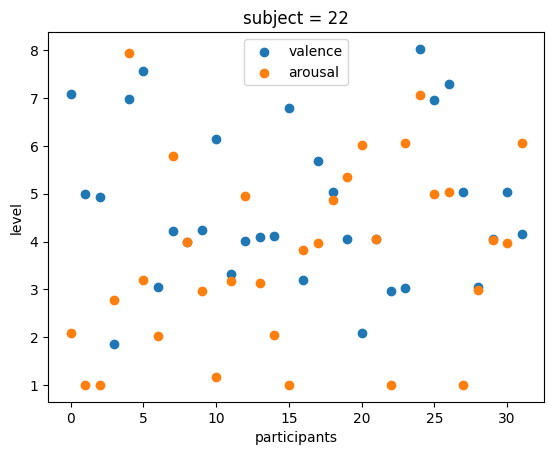

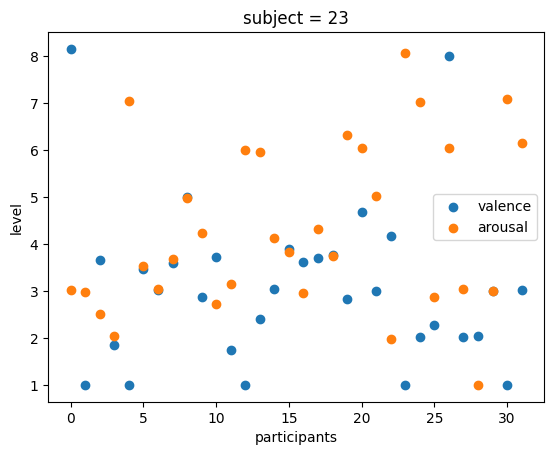

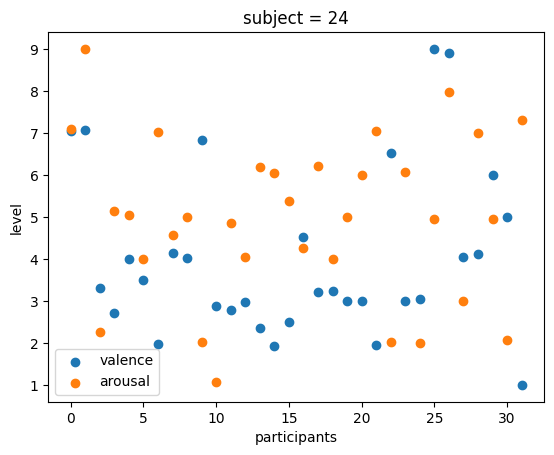

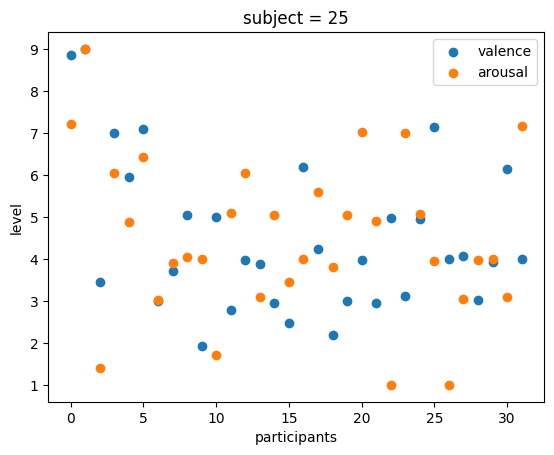

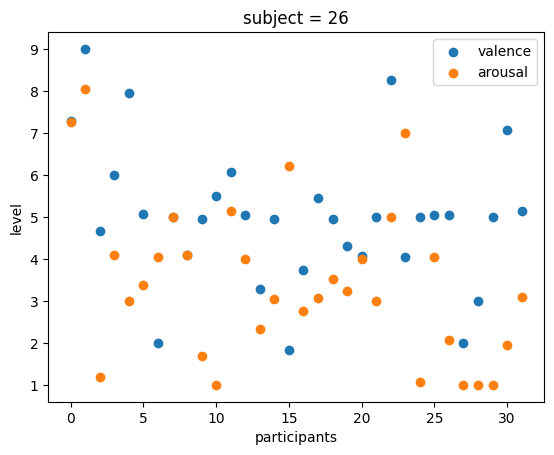

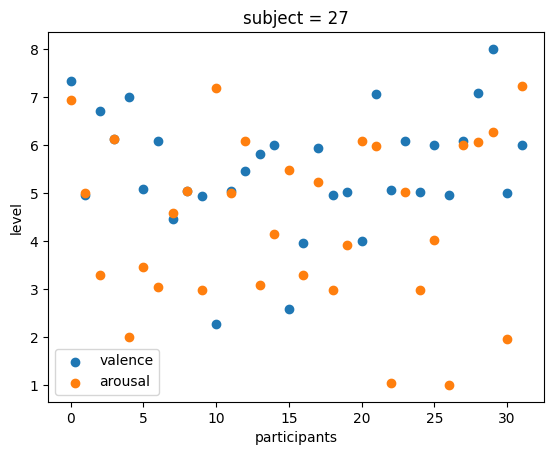

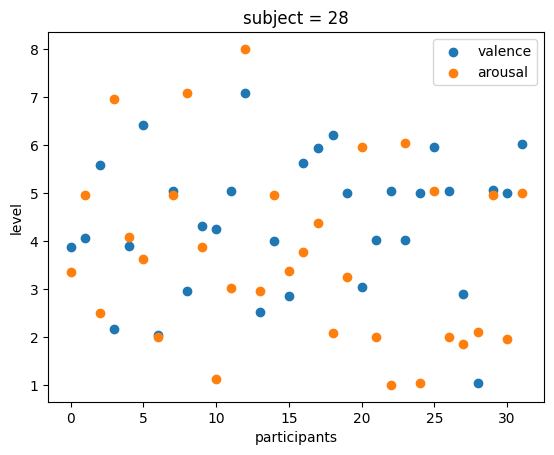

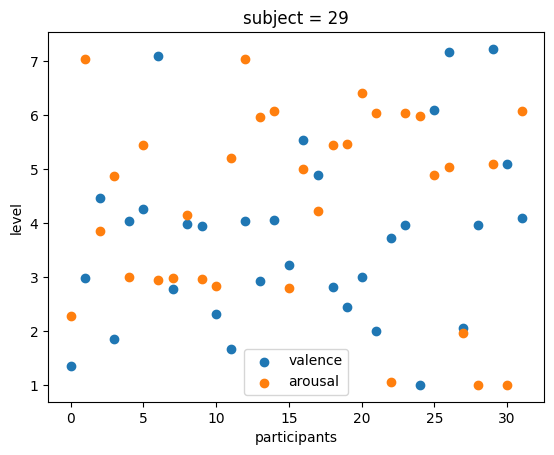

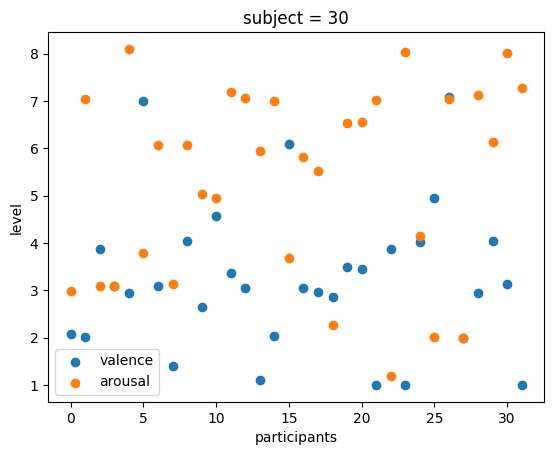

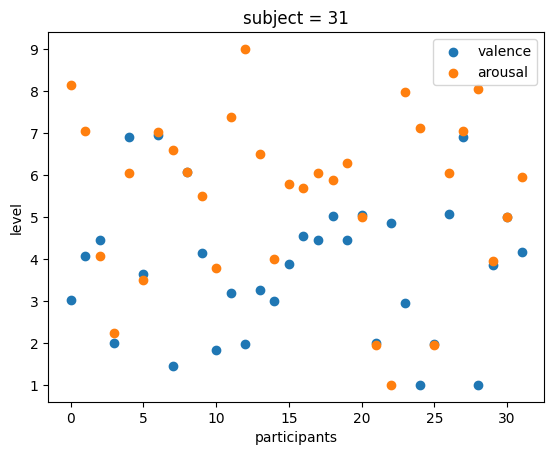

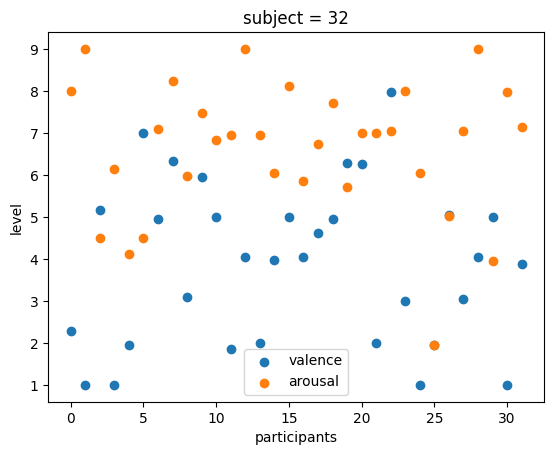

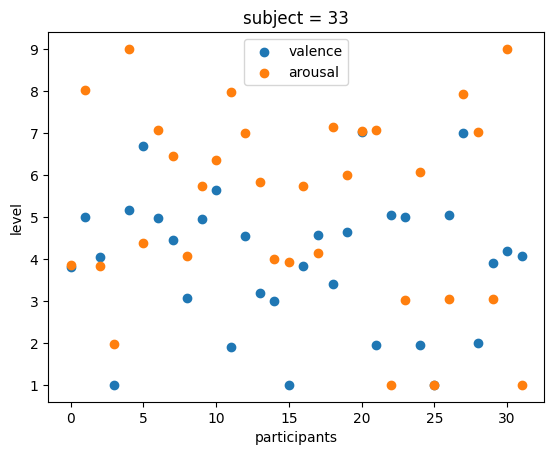

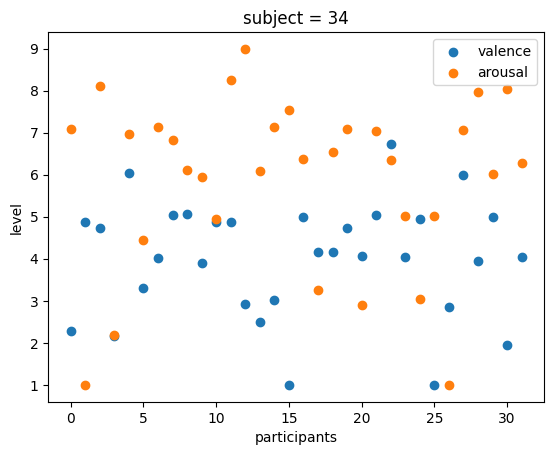

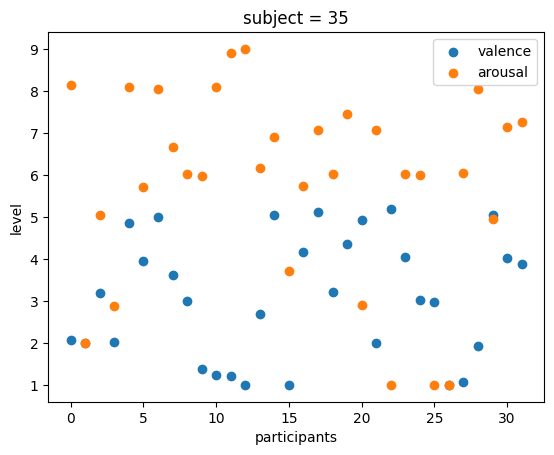

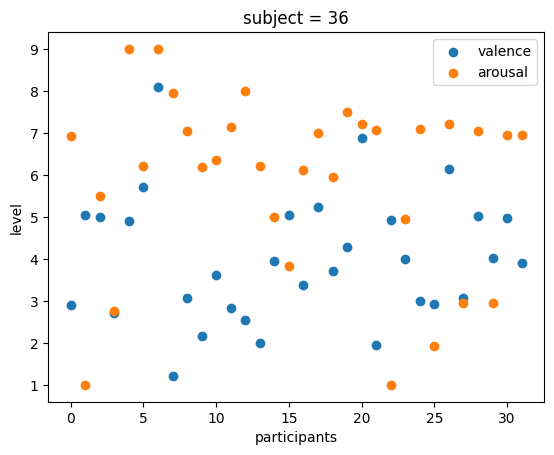

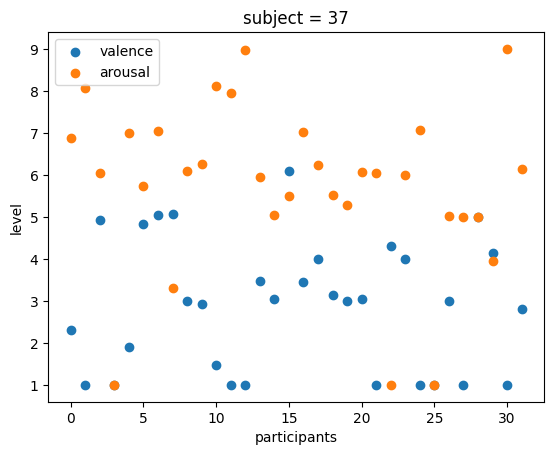

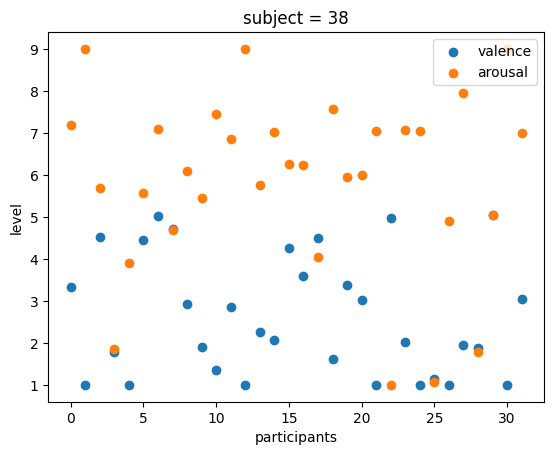

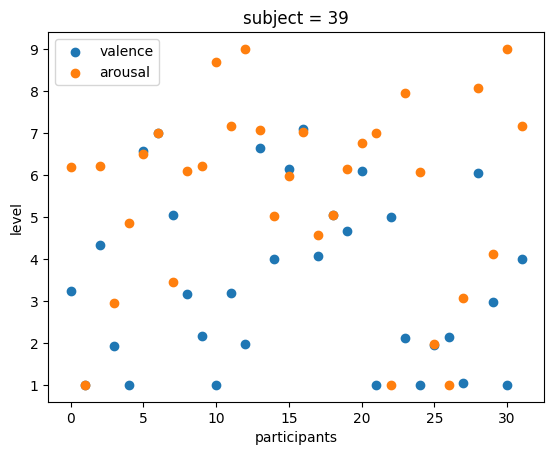

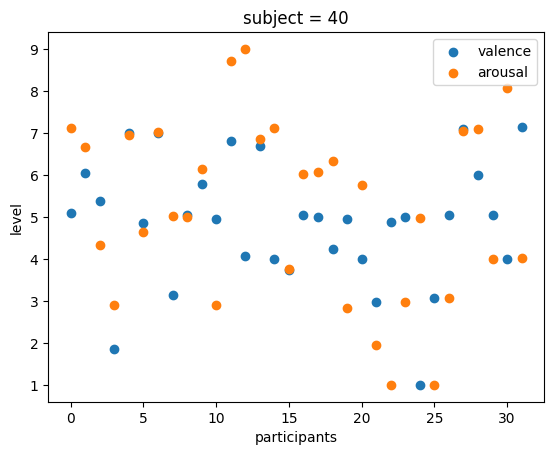

In [ ]:
#주제별로 label 살펴보기

label_valence = label_re[0, :, 0]
label_arousal = label_re[0, :, 1]

for i in label_re[1:]:
    label_valence = np.column_stack((label_valence, i[:, 0]))
    label_arousal = np.column_stack((label_arousal, i[:, 1]))

participants = np.arange(32)

print(np.shape(label_valence))

for i in range(40):
  plt.scatter(participants, label_valence[i], label = 'valence')
  plt.scatter(participants, label_arousal[i], label = 'arousal')
  plt.title('subject = {}'.format(i+1))
  plt.xlabel('participants')
  plt.ylabel('level')
  plt.legend()
  plt.show()




주제에 따라 분류하여 한 주제 안에서의 valence, arousal 각각의 분포가 비교적 일정함

# 라벨 분류하기

**전체 데이터**

In [ ]:
#0/1로 치환
binary_label = np.where(label<=4.5 ,0, 1)
print(label)
print(binary_label)

[[7.71 7.6 ]
 [8.1  7.31]
 [8.58 7.54]
 ...
 [3.05 7.01]
 [3.99 7.17]
 [7.15 4.03]]
[[1 1]
 [1 1]
 [1 1]
 ...
 [0 1]
 [0 1]
 [1 0]]


In [ ]:
def count_label(list):
  l_00 = 0
  l_01 = 0
  l_10 = 0
  l_11 = 0
  for i in list:
    if i[0] == 0 and i[1] == 0:
      l_00 +=1
    elif i[0] == 0 and i[1] == 1:
      l_01 +=1
    elif i[0] == 1 and i[1] == 0:
      l_10 +=1
    elif i[0] == 1 and i[1] == 1:
      l_11 +=1
  return l_00, l_01, l_10, l_11

print(binary_label)
print(sum(count_label(binary_label)))

[[1 1]
 [1 1]
 [1 1]
 ...
 [0 1]
 [0 1]
 [1 0]]
1280


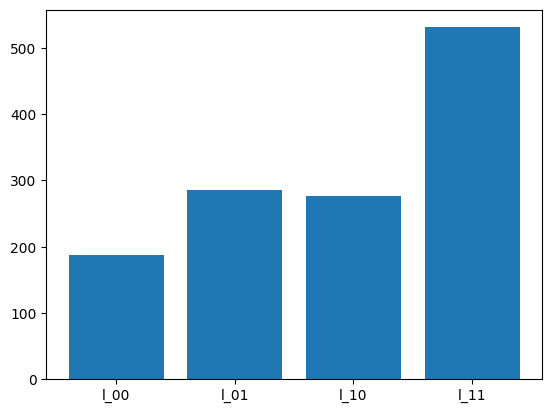

In [ ]:
plt.bar(['l_00', 'l_01', 'l_10', 'l_11'], count_label(binary_label))
plt.show()

**사람 기준 관찰**

In [ ]:
import pandas as pd

re_binary_label = binary_label.reshape(32, 40, 2)

l = []
for i in re_binary_label:
  l.append(list(count_label(i)))

df = pd.DataFrame(l, columns = ['l_00', 'l_01', 'l_10', 'l_11'])
print(df)


    l_00  l_01  l_10  l_11
0      9    11     6    14
1      4     7     9    20
2      7     3    24     6
3     17     6     5    12
4      7     5     8    20
5      4     3    17    16
6      5     5    10    20
7      4    10     5    21
8      8     9     3    20
9      6    10    11    13
10     7     6    15    12
11     2    15     3    20
12     1    19     4    16
13     5    15     8    12
14     6    12    12    10
15    12    11     8     9
16     6     8     8    18
17     4     6     9    21
18     6     8     6    20
19     1    11     5    23
20     3    12     5    20
21     4    14     7    15
22     8     0    16    16
23     1    20     4    15
24     2    14     7    17
25    12     1     8    19
26     4     3     8    25
27    11     4     9    16
28    10     7     3    20
29    10     2     5    23
30     0    11    19    10
31     1    17    10    12


**순서대로 나눴을 때**

In [ ]:
# test_size = 0.25
train_label = df.iloc[:24]
test_label = df.iloc[24:]

print(train_label)
print(test_label)

    l_00  l_01  l_10  l_11
0      9    11     6    14
1      4     7     9    20
2      7     3    24     6
3     17     6     5    12
4      7     5     8    20
5      4     3    17    16
6      5     5    10    20
7      4    10     5    21
8      8     9     3    20
9      6    10    11    13
10     7     6    15    12
11     2    15     3    20
12     1    19     4    16
13     5    15     8    12
14     6    12    12    10
15    12    11     8     9
16     6     8     8    18
17     4     6     9    21
18     6     8     6    20
19     1    11     5    23
20     3    12     5    20
21     4    14     7    15
22     8     0    16    16
23     1    20     4    15
    l_00  l_01  l_10  l_11
24     2    14     7    17
25    12     1     8    19
26     4     3     8    25
27    11     4     9    16
28    10     7     3    20
29    10     2     5    23
30     0    11    19    10
31     1    17    10    12


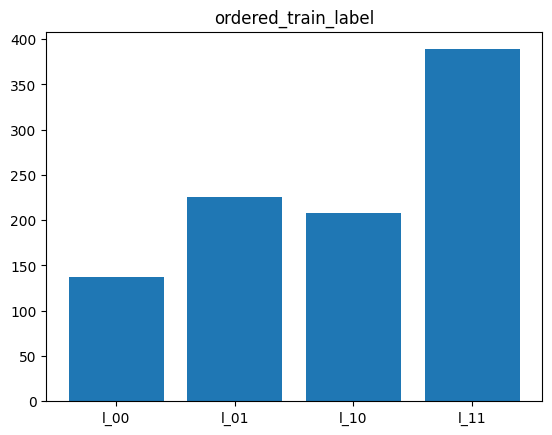

In [ ]:
plt.title('ordered_train_label')
plt.bar(['l_00', 'l_01', 'l_10', 'l_11'], [train_label['l_00'].sum(), train_label['l_01'].sum(), train_label['l_10'].sum(), train_label['l_11'].sum()])
plt.show()


**사람 기준 - 랜덤하게 나눴을 때**


In [ ]:
i = np.arange(32)
np.random.shuffle(i)
print(i)

train_index = i[:24]
test_index = i[24:]

[ 3 18 22 25 16  9  1 28 13 30  4  7 21  5  6  2 19 15 23 27 14 29 24 11
 10 31  0  8 17 20 12 26]


In [ ]:
r_train_label = df.loc[train_index, :]
r_test_label = df.loc[test_index, :]

print(r_train_label)
print(r_test_label)

    l_00  l_01  l_10  l_11
3     17     6     5    12
18     6     8     6    20
22     8     0    16    16
25    12     1     8    19
16     6     8     8    18
9      6    10    11    13
1      4     7     9    20
28    10     7     3    20
13     5    15     8    12
30     0    11    19    10
4      7     5     8    20
7      4    10     5    21
21     4    14     7    15
5      4     3    17    16
6      5     5    10    20
2      7     3    24     6
19     1    11     5    23
15    12    11     8     9
23     1    20     4    15
27    11     4     9    16
14     6    12    12    10
29    10     2     5    23
24     2    14     7    17
11     2    15     3    20
    l_00  l_01  l_10  l_11
10     7     6    15    12
31     1    17    10    12
0      9    11     6    14
8      8     9     3    20
17     4     6     9    21
20     3    12     5    20
12     1    19     4    16
26     4     3     8    25


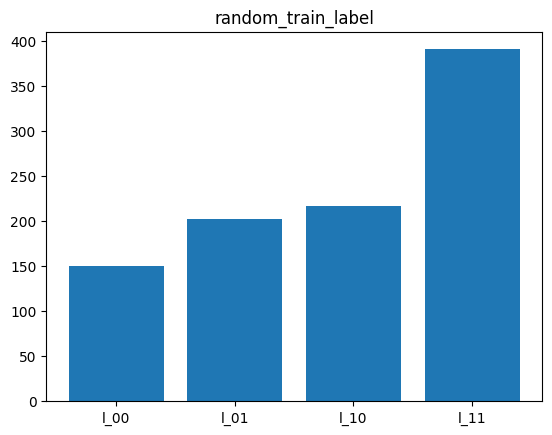

In [ ]:
plt.title('random_train_label')
plt.bar(['l_00', 'l_01', 'l_10', 'l_11'], [r_train_label['l_00'].sum(), r_train_label['l_01'].sum(), r_train_label['l_10'].sum(), r_train_label['l_11'].sum()])
plt.show()

기존 데이터의 수가 작고 기존 데이터의 l_11 레이블의 비율이 높아서 순서대로 나눴을 때와 랜덤하게 나눴을 때의 차이가 분명하지 않음

**주제 기준**


In [ ]:
label = label.reshape(32, 40, 2)
re_label = label[0]
for i in label[1:]:
  re_label = np.column_stack((re_label, i))

print(re_label)
l = re_label.reshape(40, 32, 2)
s_binary_label = np.where(l<=4.5 ,0, 1)

print(l)
print(s_binary_label)

[[7.71 7.6  9.   ... 5.97 8.13 4.83]
 [8.1  7.31 8.01 ... 7.06 4.99 2.99]
 [8.58 7.54 9.   ... 5.08 8.05 7.09]
 ...
 [3.33 7.18 1.   ... 9.   3.05 7.01]
 [3.24 6.18 1.   ... 9.   3.99 7.17]
 [5.1  7.12 6.05 ... 8.06 7.15 4.03]]
[[[7.71 7.6 ]
  [9.   5.03]
  [5.33 4.67]
  ...
  [5.04 5.04]
  [6.79 5.97]
  [8.13 4.83]]

 [[8.1  7.31]
  [8.01 7.1 ]
  [7.21 4.44]
  ...
  [7.15 6.12]
  [5.03 7.06]
  [4.99 2.99]]

 [[8.58 7.54]
  [9.   9.  ]
  [7.55 2.81]
  ...
  [6.15 5.92]
  [8.04 5.08]
  [8.05 7.09]]

 ...

 [[3.33 7.18]
  [1.   9.  ]
  [4.53 5.68]
  ...
  [5.04 5.04]
  [1.   9.  ]
  [3.05 7.01]]

 [[3.24 6.18]
  [1.   1.  ]
  [4.33 6.21]
  ...
  [2.97 4.12]
  [1.   9.  ]
  [3.99 7.17]]

 [[5.1  7.12]
  [6.05 6.67]
  [5.38 4.33]
  ...
  [5.05 3.99]
  [3.99 8.06]
  [7.15 4.03]]]
[[[1 1]
  [1 1]
  [1 1]
  ...
  [1 1]
  [1 1]
  [1 1]]

 [[1 1]
  [1 1]
  [1 0]
  ...
  [1 1]
  [1 1]
  [1 0]]

 [[1 1]
  [1 1]
  [1 0]
  ...
  [1 1]
  [1 1]
  [1 1]]

 ...

 [[0 1]
  [0 1]
  [1 1]
  ...
  [1 1]
  

In [ ]:
l = []
for i in s_binary_label:
  l.append(list(count_label(i)))

s_df = pd.DataFrame(l, columns = ['l_00', 'l_01', 'l_10', 'l_11'])
print(s_df)

    l_00  l_01  l_10  l_11
0      0     2     6    24
1      1     3     4    24
2      0     0     6    26
3      0     0     6    26
4      2     4     5    21
5      0     1     7    24
6      2     2     6    22
7      1     0     6    25
8      2     0     6    24
9      4     9     4    15
10     1     0     8    23
11     1     1    20    10
12     3     3    13    13
13     1     1     9    21
14     1     2    18    11
15    10     3    12     7
16     2     3    16    11
17     0     1    14    17
18     2     0     4    26
19     1     3     9    19
20    15     8     1     8
21    12     6     9     5
22    19     9     1     3
23     7    16     4     5
24    11     9     6     6
25     8     2    17     5
26     1     4    14    13
27    10     6    11     5
28    11    14     3     4
29     8    19     3     2
30     8    14     1     9
31     2    16     3    11
32     9     9     5     9
33     5    13     2    12
34     5    20     2     5
35     4    16     3     9
3

**순서대로 나눴을 때**

In [ ]:
# test_size = 0.25
s_train_label = s_df.iloc[:30]
s_test_label = s_df.iloc[30:]

print(s_train_label)
print(s_test_label)

    l_00  l_01  l_10  l_11
0      0     2     6    24
1      1     3     4    24
2      0     0     6    26
3      0     0     6    26
4      2     4     5    21
5      0     1     7    24
6      2     2     6    22
7      1     0     6    25
8      2     0     6    24
9      4     9     4    15
10     1     0     8    23
11     1     1    20    10
12     3     3    13    13
13     1     1     9    21
14     1     2    18    11
15    10     3    12     7
16     2     3    16    11
17     0     1    14    17
18     2     0     4    26
19     1     3     9    19
20    15     8     1     8
21    12     6     9     5
22    19     9     1     3
23     7    16     4     5
24    11     9     6     6
25     8     2    17     5
26     1     4    14    13
27    10     6    11     5
28    11    14     3     4
29     8    19     3     2
    l_00  l_01  l_10  l_11
30     8    14     1     9
31     2    16     3    11
32     9     9     5     9
33     5    13     2    12
34     5    20     2     5
3

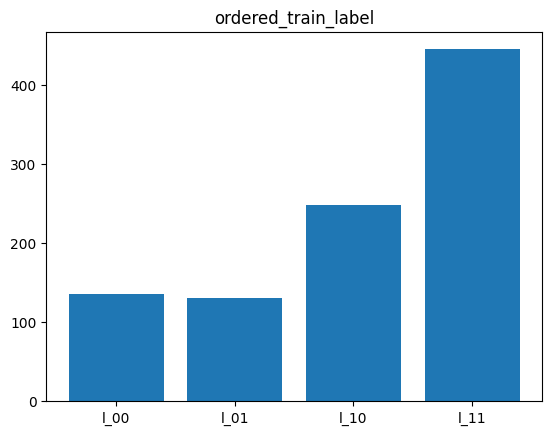

In [ ]:
#특정 열 합계 구하기
plt.title('ordered_train_label')
plt.bar(['l_00', 'l_01', 'l_10', 'l_11'], [s_train_label['l_00'].sum(), s_train_label['l_01'].sum(), s_train_label['l_10'].sum(), s_train_label['l_11'].sum()])
plt.show()

**랜덤하게 나눴을 떄**


In [ ]:
i = np.arange(40)
np.random.shuffle(i)
print(i)

train_index = i[:30]
test_index = i[30:]

[32 20 26 27 36 12 21  6 19 15  7 28  5 11  9 38 14 33  4 25 35 37 24 13
 22 18 34 39 10  0  1 16 30  8 29  2 31  3 17 23]


In [ ]:
sr_train_label = s_df.loc[train_index, :]
sr_test_label = s_df.loc[test_index, :]

print(r_train_label)
print(r_test_label)

    l_00  l_01  l_10  l_11
3     17     6     5    12
18     6     8     6    20
22     8     0    16    16
25    12     1     8    19
16     6     8     8    18
9      6    10    11    13
1      4     7     9    20
28    10     7     3    20
13     5    15     8    12
30     0    11    19    10
4      7     5     8    20
7      4    10     5    21
21     4    14     7    15
5      4     3    17    16
6      5     5    10    20
2      7     3    24     6
19     1    11     5    23
15    12    11     8     9
23     1    20     4    15
27    11     4     9    16
14     6    12    12    10
29    10     2     5    23
24     2    14     7    17
11     2    15     3    20
    l_00  l_01  l_10  l_11
10     7     6    15    12
31     1    17    10    12
0      9    11     6    14
8      8     9     3    20
17     4     6     9    21
20     3    12     5    20
12     1    19     4    16
26     4     3     8    25


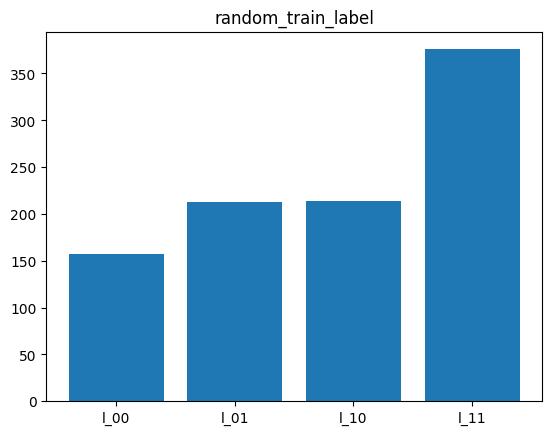

In [ ]:
#특정 열 합계 구하기
plt.title('random_train_label')
plt.bar(['l_00', 'l_01', 'l_10', 'l_11'], [sr_train_label['l_00'].sum(), sr_train_label['l_01'].sum(), sr_train_label['l_10'].sum(), sr_train_label['l_11'].sum()])
plt.show()